In [20]:
import random
import time
from typing import Dict, List, Tuple, Iterable, Sized
from copy import deepcopy
import gc
import re

from transformers import AutoTokenizer

import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
from torch.utils.data import Dataset, Subset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Зафиксируем зерна
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Используемое устройство: cuda


In [21]:
from contextlib import contextmanager

class logger:
    active = False
    _calls_ = {}
    log_file = "logger_output.txt"  # по умолчанию
    silent = True

    @classmethod
    @contextmanager
    def log(cls):

        cls.clear_log()
        cls.zero()
        cls.on()
        try:
            yield
        finally:
            cls.off()
    
    @classmethod
    def on(cls): cls.active = True

    @classmethod
    def off(cls): cls.active = False

    @classmethod
    def silent(cls, silent: bool = True):
        cls.silent = silent

    @classmethod
    def zero(cls):
        cls._calls_ = {}

    @classmethod
    def clear_log(cls):
        with open(cls.log_file, 'w') as f:
            f.write("")

    @classmethod
    def write_log(cls, msg):
        with open(cls.log_file, 'a') as f:
            f.write(msg + "\n")

    @classmethod
    def trace(cls, name):
        def log_fn(func):
            def wrapper(*args, **kwargs):
                if cls.active:
                    if name not in cls._calls_:
                        cls._calls_[name] = 0
                    msg = f'>>> {name} call {cls._calls_[name]}: \n Args: \n'
                    for i, arg in enumerate(args):
                        if isinstance(arg, torch.Tensor):
                            msg += f'\t arg[{i}]: shape={arg.shape}, dtype={arg.dtype}, device={arg.device}\n {arg} \n'
                        else:
                            msg += f'\t arg[{i}]: {arg}\n'

                    for k, arg in kwargs.items():
                        if isinstance(arg, torch.Tensor):
                            msg += f'\t kwarg[{k}]: shape={arg.shape}, dtype={arg.dtype}, device={arg.device}\n {arg} \n'
                        else:
                            msg += f'\t kwarg[{k}]: {arg} \n'

                    if not cls.silent: print(msg)
                    cls.write_log(msg)

                result = func(*args, **kwargs)

                if cls.active:
                    msg = f'Result: \n'
                    if isinstance(result, Iterable):
                        for i, outp in enumerate(result):
                            if isinstance(outp, torch.Tensor):
                                msg += f'\t output[{i}]: shape={outp.shape}, dtype={outp.dtype}, device={outp.device}\n {outp} \n'
                            else:
                                msg += f'\t output[{i}]: {outp}\n'
                    elif isinstance(result, torch.Tensor):
                        msg = f'\t output: shape={result.shape}, dtype={result.dtype}, device={result.device}\n {result} \n'
                    else:
                        msg += f'\t output: {result}\n'

                    if not cls.silent: print(msg)
                    cls.write_log(msg)
                    cls._calls_[name] += 1

                return result
            return wrapper

        return log_fn

# 1. Токенизатор и эмбеддинги

In [22]:
from transformers import AutoModel

In [23]:
mobilebert = AutoModel.from_pretrained("google/mobilebert-uncased")

/home/student/miniconda3/envs/nn_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
torchinfo.summary(mobilebert)

Layer (type:depth-idx)                                       Param #
MobileBertModel                                              --
├─MobileBertEmbeddings: 1-1                                  --
│    └─Embedding: 2-1                                        3,906,816
│    └─Embedding: 2-2                                        262,144
│    └─Embedding: 2-3                                        1,024
│    └─Linear: 2-4                                           197,120
│    └─NoNorm: 2-5                                           1,024
│    └─Dropout: 2-6                                          --
├─MobileBertEncoder: 1-2                                     --
│    └─ModuleList: 2-7                                       --
│    │    └─MobileBertLayer: 3-1                             842,240
│    │    └─MobileBertLayer: 3-2                             842,240
│    │    └─MobileBertLayer: 3-3                             842,240
│    │    └─MobileBertLayer: 3-4                             

In [25]:
bert_word_embedding = deepcopy(mobilebert.embeddings.word_embeddings)
del mobilebert

In [26]:
print(bert_word_embedding.weight.shape)

torch.Size([30522, 128])


In [27]:
from transformers import AutoTokenizer
# https://huggingface.co/docs/transformers/main_classes/tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
VOCAB_SIZE = tokenizer.vocab_size
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


In [28]:
def collect_special_tokens(tokenizer: AutoTokenizer) -> Dict:

    special_tokens = ['PAD', 'BOS', 'EOS', 'UNK', 'SEP', 'CLS']
    outp = {}
    for name in special_tokens:
        token = getattr(tokenizer, f'{name.lower()}_token')
        if token is not None:
            outp[name] = token
            outp[f'{name}_id'] = getattr(tokenizer, f'{name.lower()}_token_id')
        else:
            print(f'{name} token  is not present in tokenizer')
    
    for name in special_tokens:
        if name in outp:
            print(f'{name} token: token {outp[name]}, id {outp[f'{name}_id']}')

    return outp

special_tokens = collect_special_tokens(tokenizer)

for k, v in special_tokens.items():
    globals()[k] = v

BOS token  is not present in tokenizer
EOS token  is not present in tokenizer
PAD token: token [PAD], id 0
UNK token: token [UNK], id 100
SEP token: token [SEP], id 102
CLS token: token [CLS], id 101


In [29]:
# Будем использовать CLS в качестве BOS и SEP в качестве EOS

In [30]:
text = 'NLP (Neuro-Linguistic Programming) is a psychological approach that involves analyzing the patterns of thought, language, and behavior to understand how they interact with and influence human experience. There is no scientific evidence supporting the effectiveness of NLP; it is recognized as a pseudoscience.'
# apply tokenizer:
seq = tokenizer(text)
print(seq)
# decode with tokenizer:
print(tokenizer.decode(seq['input_ids']))

{'input_ids': [101, 17953, 2361, 1006, 11265, 10976, 1011, 12158, 4730, 1007, 2003, 1037, 8317, 3921, 2008, 7336, 20253, 1996, 7060, 1997, 2245, 1010, 2653, 1010, 1998, 5248, 2000, 3305, 2129, 2027, 11835, 2007, 1998, 3747, 2529, 3325, 1012, 2045, 2003, 2053, 4045, 3350, 4637, 1996, 12353, 1997, 17953, 2361, 1025, 2009, 2003, 3858, 2004, 1037, 18404, 11020, 13684, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS] nlp ( neuro - linguistic programming ) is a psychological approach that involves analyzing the patterns of thought, language, and behavior to understand how they interact with and influence human experience. there is no s

In [31]:
texts = ['NLP (Neuro-Linguistic Programming) is a psychological approach that involves analyzing the patterns of thought, language, and behavior to understand how they interact with and influence human experience.',
         'There is no scientific evidence supporting the effectiveness of NLP; it is recognized as a pseudoscience.']
seq = tokenizer(text, max_length=64, padding="max_length",\
                truncation="longest_first", return_tensors="pt",\
                return_token_type_ids = False, return_length=True)
print(seq)
# decode with tokenizer:
print(tokenizer.decode(seq['input_ids'][0]))

{'input_ids': tensor([[  101, 17953,  2361,  1006, 11265, 10976,  1011, 12158,  4730,  1007,
          2003,  1037,  8317,  3921,  2008,  7336, 20253,  1996,  7060,  1997,
          2245,  1010,  2653,  1010,  1998,  5248,  2000,  3305,  2129,  2027,
         11835,  2007,  1998,  3747,  2529,  3325,  1012,  2045,  2003,  2053,
          4045,  3350,  4637,  1996, 12353,  1997, 17953,  2361,  1025,  2009,
          2003,  3858,  2004,  1037, 18404, 11020, 13684,  1012,   102,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]), 'length': tensor([64])}
[CLS] nlp ( neuro - linguistic programming ) is a psychological approach that involves analyzing the patterns of thought, language, and behavior to understand how they interact with and influence human experi

In [32]:
# Возвращается не словарь, а свой тип, имеющий  методы Dict() и другие 
type(seq)

transformers.tokenization_utils_base.BatchEncoding

In [33]:
print(*seq.tokens())

[CLS] nl ##p ( ne ##uro - linguistic programming ) is a psychological approach that involves analyzing the patterns of thought , language , and behavior to understand how they interact with and influence human experience . there is no scientific evidence supporting the effectiveness of nl ##p ; it is recognized as a pseudo ##sc ##ience . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]


In [34]:
print(''.join([_attr_+'   ' for _attr_ in dir(seq)]))

_MutableMapping__marker   __abstractmethods__   __class__   __class_getitem__   __contains__   __copy__   __delattr__   __delitem__   __dict__   __dir__   __doc__   __eq__   __format__   __ge__   __getattr__   __getattribute__   __getitem__   __getstate__   __gt__   __hash__   __init__   __init_subclass__   __ior__   __iter__   __le__   __len__   __lt__   __module__   __ne__   __new__   __or__   __reduce__   __reduce_ex__   __repr__   __reversed__   __ror__   __setattr__   __setitem__   __setstate__   __sizeof__   __slots__   __str__   __subclasshook__   __weakref__   _abc_impl   _encodings   _n_sequences   char_to_token   char_to_word   clear   convert_to_tensors   copy   data   encodings   fromkeys   get   is_fast   items   keys   n_sequences   pop   popitem   sequence_ids   setdefault   to   token_to_chars   token_to_sequence   token_to_word   tokens   update   values   word_ids   word_to_chars   word_to_tokens   words   


In [35]:
print(seq.input_ids)

tensor([[  101, 17953,  2361,  1006, 11265, 10976,  1011, 12158,  4730,  1007,
          2003,  1037,  8317,  3921,  2008,  7336, 20253,  1996,  7060,  1997,
          2245,  1010,  2653,  1010,  1998,  5248,  2000,  3305,  2129,  2027,
         11835,  2007,  1998,  3747,  2529,  3325,  1012,  2045,  2003,  2053,
          4045,  3350,  4637,  1996, 12353,  1997, 17953,  2361,  1025,  2009,
          2003,  3858,  2004,  1037, 18404, 11020, 13684,  1012,   102,     0,
             0,     0,     0,     0]])


# 2. Данные и контейнеры

In [36]:
%%bash
data_dir="../data"
csv_name="1_Recipe_csv.csv"
zip_name="recipes-dataset-64k.zip"
zip_path="$data_dir/$zip_name"

if [ ! -d "$data_dir" ]; then
    mkdir -p "$data_dir"
    echo "Directory created: $data_dir"
else
    echo "Found data directory: $data_dir"
fi

if [ ! -f "$data_dir/$csv_name" ]; then
    echo "CSV file $csv_name not found..."
    if [ ! -f "$zip_path" ]; then
        echo "Archive $zip_name not found, downloading..."
        curl -L -o "$zip_path" https://www.kaggle.com/api/v1/datasets/download/prashantsingh001/recipes-dataset-64k-dishes
        echo "Dataset downloaded: $zip_path"
    else
        echo "Found archive $zip_name"
    fi
    echo "Extracting to $data_dir ..."
    unzip "$zip_path" -d "$data_dir"
    echo "Dataset unzipped to: $data_dir"
else
    echo "Found dataset: $data_dir/$csv_name"
fi

Found data directory: ../data
Found dataset: ../data/1_Recipe_csv.csv


In [37]:
class RecipeDataset(Dataset):

    def __init__(
            self, 
            path: str,
            tokenizer: AutoTokenizer,
            source_columns: List[str],
            target_columns: List[str] = None,
            nrows = None,
            device = 'cpu',
            max_len = 256,
            padding_type = "max_length",
            ):

        self.source_columns = source_columns
        self.target_columns = target_columns if target_columns else source_columns

        columns = source_columns
        if target_columns:
            columns += target_columns
        
        data = pd.read_csv(path, usecols=list(set(columns)), nrows=nrows)

        self.src_ = []
        self.tgt_ = []
        self.tokenizer = tokenizer
        self.CLS_id = tokenizer.cls_token_id
        self.SEP_id = tokenizer.sep_token_id
        self.device = device
        self.PAD_idx = tokenizer.pad_token_id
        self.max_len = max_len
        self.padding_type = padding_type

        for i in tqdm.trange(len(data)):
            row = data.iloc[i]
            src_text = self.process_row(row, source_columns)
            self.src_.append(src_text)
            
            if target_columns is not None:
                tgt_text = self.process_row(row, target_columns) 
                self.tgt_.append(tgt_text)
        
        if target_columns is None:
            self.tgt_ = self.src_
        
        self.size = len(self.src_)

    def process_row(self, row: pd.Series, columns: List[str]):
        """Processes a single recipe row from the DataFrame into a clean string."""
        entry_parts = []
        for col in columns:
            if pd.notna(row[col]):
                content = str(row[col])
                if content.startswith('[') and content.endswith(']'):
                    content = re.sub(r'["\\$$\\\\$$]', '', content)
                entry_parts.append(f'{col.replace("_", " ")}: {content}')
                entry_parts.append('\n')
        return ''.join(entry_parts[:-1])

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> Tuple[str, str]:
        source = self.src_[idx]
        target = self.tgt_[idx]
        return source, target

    def to(self, device='cpu', dtype=None):
        
        if device is not None:
            if self.device != device:
                clone = deepcopy(self)
                clone.device = device
                return clone
            else:
                return self
        # if dtype is not None:
        #     return self

    def single(self, idx):
        return self.collate_fn([(self.src_[idx], self.tgt_[idx])])

    def collate_fn(self, batch: List[Tuple[str, str]]) -> Dict[str, List]:
        
        sources = [f[0] for f in batch]
        targets = [f[1] for f in batch]
    
        source_enc = self.tokenizer(list(sources), max_length=self.max_len, 
                                    padding=self.padding_type, truncation=True, 
                                    return_tensors="pt").to(device=self.device)

        target_enc = self.tokenizer(list(targets), max_length=self.max_len,
                                    padding=self.padding_type, truncation=True, 
                                    return_tensors="pt").to(device=self.device)
        return {
            'input_ids': source_enc['input_ids'], 
            'input_mask': source_enc['attention_mask'],
            'input_lengths': source_enc['attention_mask'].sum(dim=-1),
            'labels': target_enc['input_ids'],
            'labels_mask': target_enc['attention_mask'],
            'labels_lengths': target_enc['attention_mask'].sum(dim=-1),   
            }


In [38]:
DATA_PATH = '../data/1_Recipe_csv.csv'
NSAMPLES = 48000

copy_dataset = RecipeDataset(DATA_PATH, tokenizer, ['description', 'ingredients'], None,\
                     nrows=NSAMPLES, padding_type="longest", device='cpu')

ingredients_dataset = RecipeDataset(DATA_PATH, tokenizer, ['recipe_title', 'description'], ['ingredients'],\
                     nrows=NSAMPLES, padding_type="longest", device='cpu')

recipe_dataset = RecipeDataset(DATA_PATH, tokenizer, ['recipe_title', 'description'], ['ingredients', 'directions'],\
                     nrows=NSAMPLES, padding_type="longest", device='cpu')

100%|██████████| 48000/48000 [00:01<00:00, 39086.35it/s]


In [39]:
idx = np.random.randint(0, NSAMPLES)
print(copy_dataset[idx][0])
print(copy_dataset[idx][1])

description: This chocolate Yule log is a festive holiday cake. Merry Christmas! You will need cinnamon red hard candies and snowmen candy for decorations.
ingredients: [u00bd cup sifted cake flour, u00bc cup unsweetened cocoa powder, 1 teaspoon baking powder, u00bc teaspoon salt, u00bd cup white sugar, 3 large eggs, separated, u00bc cup milk, 2 tablespoons confectioners' sugar, 1 u00bd cups prepared whipped cream]
description: This chocolate Yule log is a festive holiday cake. Merry Christmas! You will need cinnamon red hard candies and snowmen candy for decorations.
ingredients: [u00bd cup sifted cake flour, u00bc cup unsweetened cocoa powder, 1 teaspoon baking powder, u00bc teaspoon salt, u00bd cup white sugar, 3 large eggs, separated, u00bc cup milk, 2 tablespoons confectioners' sugar, 1 u00bd cups prepared whipped cream]


In [40]:
def get_dataloaders(dataset: RecipeDataset,
                    train_ratio=0.8,
                    val_ratio=0.1,
                    batch_size=1,
                    load_ratio = 1.0,
                    device='cpu',
                   ):
    """
    Loads data, splits it, and creates train, validation, and test DataLoaders.
    """
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    train_end = int(len(indices) * train_ratio * load_ratio)
    val_end = int(len(indices) * (train_ratio + val_ratio) * load_ratio)
    test_end = int(len(indices) * load_ratio)
    
    dataset = dataset.to(device=device)
    collate_fn = dataset.collate_fn
    train_set = Subset(dataset, indices[:train_end])
    val_set = Subset(dataset, indices[train_end:val_end])
    test_set = Subset(dataset, indices[val_end:test_end])

    print(f"Data split:")
    print(f"Training set size: {len(train_set)}")
    print(f"Validation set size: {len(val_set)}")
    print(f"Test set size: {len(test_set)}")

    if batch_size >= 1:
        print("Using batching with padding. Ensure your training loop can handle batched data!")
        
    return {
        'train':DataLoader(train_set, batch_size, shuffle=True, collate_fn=collate_fn), 
        'val': DataLoader(val_set, batch_size, shuffle=False, collate_fn=collate_fn), 
        'test': DataLoader(test_set, batch_size, shuffle=False, collate_fn=collate_fn),
        }  

dataloaders = get_dataloaders(ingredients_dataset, batch_size=16, load_ratio=0.01)

Data split:
Training set size: 384
Validation set size: 48
Test set size: 48
Using batching with padding. Ensure your training loop can handle batched data!


In [41]:
batch_n = 1
n = 0

for X in dataloaders['test']:
    if n == batch_n:
         print(X)
    elif n > batch_n:
        break
    n += 1      

{'input_ids': tensor([[  101, 17974,  2516,  ...,  2378,  1033,   102],
        [  101, 17974,  2516,  ...,     0,     0,     0],
        [  101, 17974,  2516,  ...,     0,     0,     0],
        ...,
        [  101, 17974,  2516,  ...,     0,     0,     0],
        [  101, 17974,  2516,  ...,     0,     0,     0],
        [  101, 17974,  2516,  ...,     0,     0,     0]]), 'input_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'input_lengths': tensor([222, 205,  97, 156, 140, 135, 109, 207, 157, 119, 134, 154, 104,  96,
        174, 126]), 'labels': tensor([[  101, 12760,  1024,  ...,     0,     0,     0],
        [  101, 12760,  1024,  ...,     0,     0,     0],
        [  101, 12760,  1024,  ...,     0,     0,     0],
        ...,
        [  101, 12760,  1024,  ...,     0,     0,     0],
        [  101, 1276

# 3.1. Seq2seq без внимания

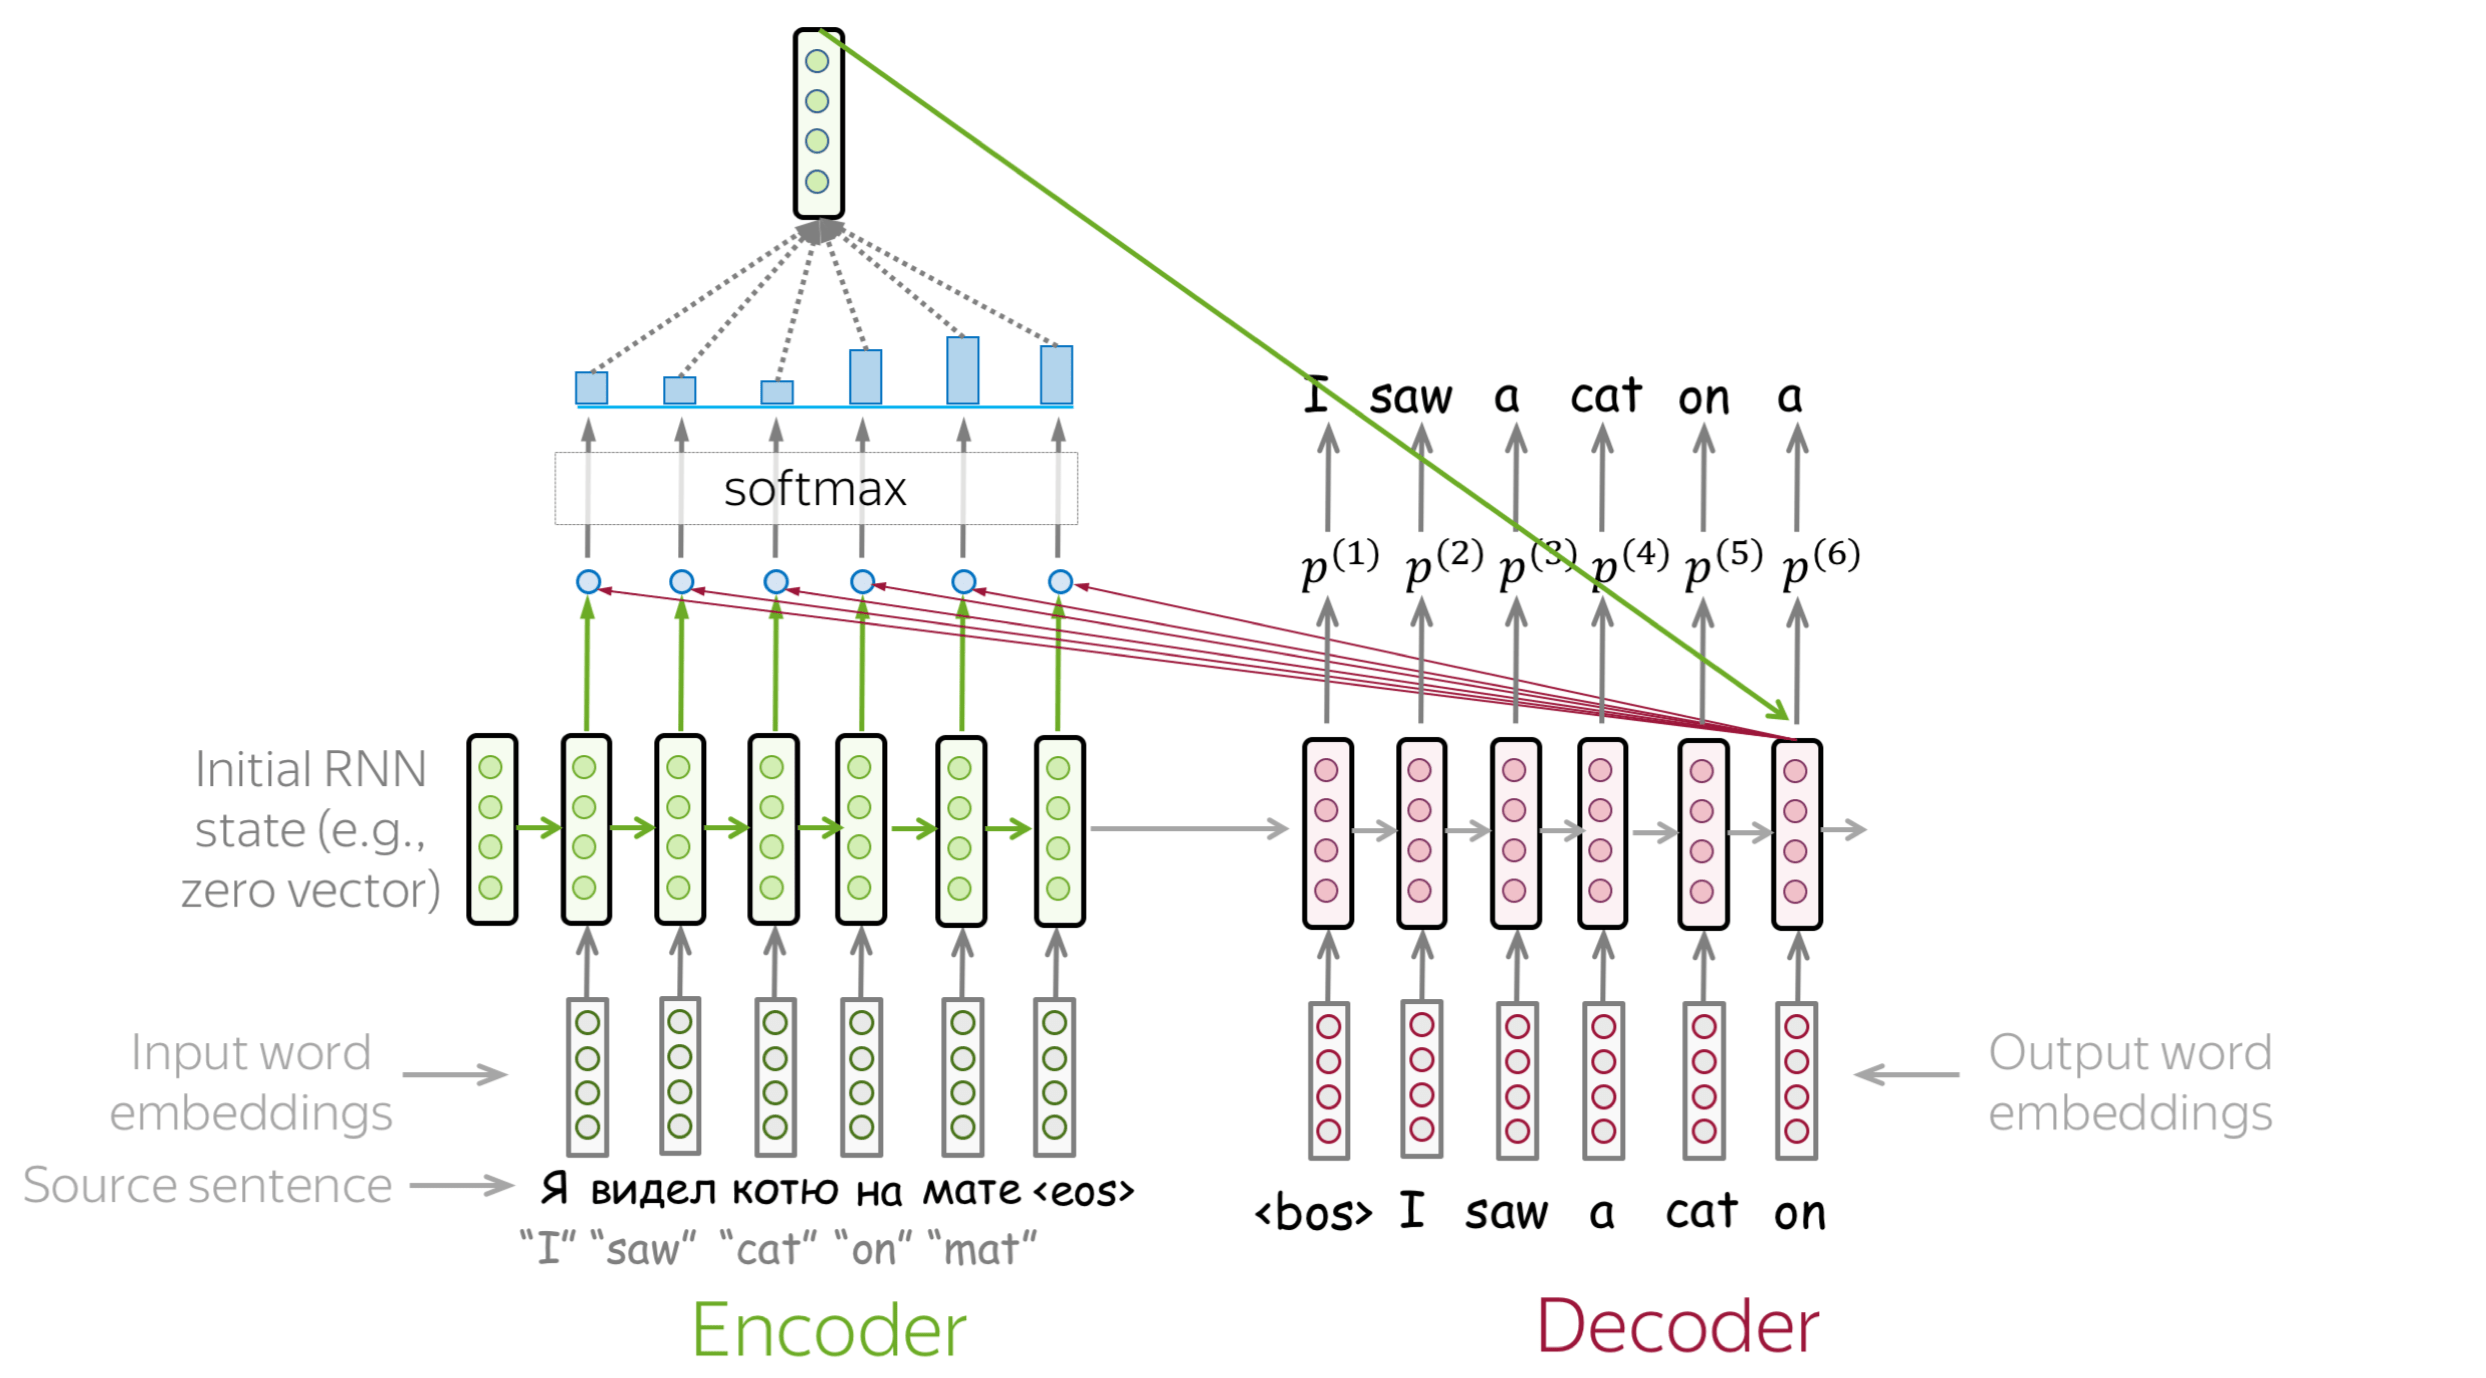


In [44]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, output_size, num_layers=1, dropout_rate=0.0):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, output_size, num_layers, 
                          batch_first=True, bidirectional=True)
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(self.dropout_rate)

    @logger.trace('ENC')
    def forward(self, x):
        """
        Applies a bidirectional GRU to sequence of embeddings x.

        Args:
            - x should have dimensions [batch, seq_len, emb_dim].
        """
        x = self.dropout(x)
        lengths = torch.IntTensor([x.shape[1] for _ in range(x.shape[0])]).cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        
        output, hidden = self.rnn(packed) # [B, SEQ_LEN, bidir*EMB_DIM], [N_layers*bidir, B, EMB_DIM], 
        output, _ = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden

In [45]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    def __init__(self, context_size, hidden_size, enc_hidden, num_layers=1, 
                 dropout_rate=0.5, max_steps = 256, bridge=True):
        super(Decoder, self).__init__()
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.rnn = nn.GRU(context_size + hidden_size, hidden_size,
                          num_layers, batch_first=True)
        self.dropout = nn.Dropout(self.dropout_rate)
        # Для инициализации из конечного состояния энкодера
        self.bridge = nn.Linear(2*enc_hidden, hidden_size, bias=True) if bridge else nn.Ident()

    @logger.trace('DEC')
    def forward(self, context, prev, hidden=None, src_mask=None):
        """One step of the decoder.
        Args:
            - context: torch.Tensor [B, SEQ_LEN, CONTEXT]
            - prev: initial vector or prediction on previous step
            - src_mask
        """
        context = context.sum(dim=1) ## Attention will be here

        x = torch.cat((context, prev), dim=-1).unsqueeze(1)
        
        output, hidden = self.rnn(x, hidden) 
        # [B, CON+HIDDEN*dec_bidir], [N_layers*dec_bidir, B, EMB_DIM], 
        return output.squeeze(1), hidden

    @logger.trace('DEC_hid_init')
    def init_hidden(self, encoder_hidden):

        X = torch.cat((encoder_hidden[0, ...], encoder_hidden[1, ...]), dim=-1)
        X = torch.tanh(self.bridge(X))
        
        return X.unsqueeze(0)

In [96]:
import torch.nn as nn

class Seq2Seq(nn.Module):
    """
    A standard Seq2Seq architectue
    """
    def __init__(self,
            tokenizer, embedding,
            hidden_size, n_layers, dropout_rate,
            EncoderCls, DecoderCls,
            max_steps=256, bridge=True, tie_projection=False,
        ):
        """
        Args:
            - tokenizer: AutoTokenizer - input text tokenizer
            - embedding: nn.Embedding - pre-trained embedding
            - n_layers: number of layers in rnn
            - cls: encoder class to use, must match signature (),
            - decoder_cls: decoder class to use, must match signature (),
            - tie_projection: bool - if true, embedding and projection layer will use same weights
        """
        super(Seq2Seq, self).__init__()
        self.tokenizer = tokenizer
        self.embedding = embedding
        self.embed_dim = embedding.embedding_dim
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.max_steps = max_steps
        self.tie_projection = tie_projection
        
        self.CLS_id = torch.IntTensor([tokenizer.cls_token_id])
        self.SEP_id = torch.IntTensor([tokenizer.sep_token_id])
        self.vocab_size = tokenizer.vocab_size

        self.EncoderCls = EncoderCls
        self.DecoderCls = DecoderCls
        
        self.encoder = EncoderCls(self.embed_dim, hidden_size, n_layers, dropout_rate)
        self.decoder = DecoderCls(hidden_size*2, self.embed_dim, hidden_size, n_layers, dropout_rate, bridge=bridge)
        
        self.comment = None
        self.defaultpath = '../'

        self.teacher_forcing = None

        for param in self.embedding.parameters():
            param.requires_grad = False
        
        if tie_projection:
            self.projection = nn.Sequential(
                nn.Linear(self.embed_dim, self.embed_dim),
                nn.ReLU(),
                nn.Linear(self.embed_dim, self.vocab_size, bias=False),
                )
            self.projection[-1].weight = self.embedding.weight
        else:
            self.projection = nn.Linear(self.embed_dim, self.vocab_size, bias=False)
    
    @logger.trace('MODEL')
    def forward(self, tokens, src_lengths=None, src_mask=None, tgt_lenghts=None, tgt_mask=None, nsteps=None):
        '''
        Forward pass of the model
        Args:
            - tokens: torch.IntTensor of shape [batch, sequence_len]
        Returns: dict
        
        '''
        input_device = self.embedding.weight.device
        if tokens.device != input_device:
            tokens = tokens.to(device=input_device)
            
        batch_size = tokens.shape[0]
        if nsteps == None: nsteps = self.max_steps
        if tgt_lenghts != None: nsteps = min(nsteps, max(tgt_lenghts))

        # Считываем токены в обратной последовательности, 
        # так RNN будет лучше помнить токены начала предложения
        embed = self.embedding(tokens.flip(dims=[1]))
        context, enc_hidden = self.encoder.forward(embed)
        
        # ID специальных токенов должны быть на том же устройстве(увы)
        SEP, CLS = self.SEP_id.to(device=input_device), self.CLS_id.to(device=input_device)
        
        # Следующие величины понадобятся для цикла декодера 
        prev = self.embedding(CLS).repeat(batch_size, 1)
        active = torch.ones(batch_size, dtype=torch.bool).to(device=input_device)
    
        logits = torch.zeros(batch_size, nsteps, self.vocab_size,
                             dtype=prev.dtype).to(device=input_device)
        pred_tokens = torch.zeros(batch_size, nsteps, dtype=tokens.dtype).to(device=input_device)
        dec_hidden = self.decoder.init_hidden(enc_hidden)

        last = nsteps        
        for i in range(nsteps):
            # Запускаем декодер 
            # YOUR CODE
            dec_outputs, dec_hidden = self.decoder(context[active, ...], prev[active, ...], dec_hidden[:, active, ...])

            proj_ = self.projection(dec_outputs) # [B_, VOCAB_SIZE]
            logits[active, i, :] = F.log_softmax(proj_, dim=-1)
            
            proj_, idxs_ = proj_.max(dim=-1) #[B_], [B_]
            
            pred_tokens[active, i] = idxs_
            prev[active, ...] = dec_outputs

            if self.training and self.teacher_forcing:
                prev = self.teacher_forcing(i, prev)
            
        return {
            'tokens': pred_tokens[:, :last], 
            'logits': logits[:, :last, :],
            }
    
    def predict(self, text, nsteps=128):

        tokens = self.tokenizer(text, padding='longest', return_tensors='pt')
        pred = model.forward(tokens['input_ids'], nsteps=nsteps)
        output_text = self.tokenizer.batch_decode(sequences=pred['tokens'].cpu())
        
        return output_text

model = Seq2Seq(
    tokenizer=tokenizer,
    embedding=bert_word_embedding,
    hidden_size=128,
    n_layers=1,
    dropout_rate=0.1,
    EncoderCls=Encoder,
    DecoderCls=Decoder,
    tie_projection=True,
    )

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Embedding: 1-1                         (3,906,816)
├─Encoder: 1-2                           --
│    └─GRU: 2-1                          198,144
│    └─Dropout: 2-2                      --
├─Decoder: 1-3                           --
│    └─GRU: 2-3                          197,376
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       32,896
├─Sequential: 1-4                        --
│    └─Linear: 2-6                       16,512
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       (3,906,816)
Total params: 8,258,560
Trainable params: 444,928
Non-trainable params: 7,813,632

In [58]:
with logger.log(), torch.no_grad():
    model.cuda().eval()
    print(model.predict(
            ['recipe title: how to deal with bugs on your computer',
             'directions: get rid of windows and install linux'],
            nsteps=10))

['##chai 00 00 00 00 00 00 00 00 00', '##marksmarksmarksmarksmarksmarksmarksmarksmarksmarks']


In [59]:
 torchinfo.summary(model, input_data=next(dataloaders['train'].__iter__())['input_ids'], nsteps=5)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [16, 5, 30522]            --
├─Embedding: 1-1                         [16, 220, 128]            (3,906,816)
├─Encoder: 1-2                           --                        --
│    └─Dropout: 2-1                      [16, 220, 128]            --
│    └─GRU: 2-2                          [3520, 256]               198,144
├─Embedding: 1-3                         [1, 128]                  (recursive)
├─Decoder: 1-4                           --                        (recursive)
│    └─Linear: 2-3                       [16, 128]                 32,896
├─Decoder: 1-5                           [16, 128]                 32,896
│    └─GRU: 2-4                          [16, 1, 128]              197,376
├─Sequential: 1-6                        [16, 30522]               --
│    └─Linear: 2-5                       [16, 128]                 16,512
│    └─ReLU: 2-6                    

# 3.2 Цикл обучения и другие рутины, тесты

In [76]:
IDTYPE = torch.int32
FDTYPE = torch.float32 
FDTYPE2 = torch.half
# С сокращёнными типами проблема - нет поддержки дропаута "из коробки"
FDTYPE3 = torch.float8_e4m3fn

In [60]:
class GradientCatcher:

    epoch_criterion = lambda epoch: True
    batch_criterion = lambda batch: batch == 0
    reduction = lambda grad: abs(grad).mean().item()
    
    @classmethod
    def write_grads(cls, epoch, batch, model: nn.Module, path):
        
        if cls.epoch_criterion(epoch) and cls.batch_criterion(batch):

            msg = f">>> EPOCH {epoch}, batch {batch} ::::: {time.asctime(time.gmtime())} \n"
                
            for name, param in model.named_parameters():
                if param.grad is not None:
                    grad = cls.reduction(param.grad.detach().cpu())
                else: grad = None
                    
                msg+= f"\t{name}: {cls.fmt(grad)}\n"
            
            msg += f"\n"            
            with open(path, 'a') as f: f.write(msg)  

    @staticmethod
    def fmt(grad):
        if grad is None: return None
        elif isinstance(grad, float): return f"{grad:.2e}"
        elif isinstance(grad, torch.Tensor): return f"{grad}"
        else:
            try: msg = f"{grad}"
            except: msg = "unk"


In [89]:
class Evaluation:

    eval_fns: Dict[str, callable] = {}

    max_len = 8192
    loader_keys = {'train_score': 'train', 'val_score': 'val'}
    
    @classmethod
    def evaluate(cls, epoch, model, dataloaders, history):

        model.eval()
        with torch.no_grad():
            for case, data_key in cls.loader_keys.items():
                for name, fn in eval_fns.items():
                    history[case][name].append(
                        cls.eval_fn_dl(model, dataloaders[data_key], cls.eval_fns[name]))
        
        history['epochs'].append(epoch)

    @classmethod
    def init_history(cls, history=None):
        if history is None: history={}
        for case in cls.loader_keys.keys():
            if case not in history:
                history[case] = {}
            for name in cls.eval_fns.keys():
                if name not in history[case]:
                    history[case][name] = []     

        return history

    @classmethod
    def eval_on_dl(cls, model, loader, score_fn):

        model.eval()
        score = 0
        n_tokens = 0
        with torch.no_grad():
            for batch in loader:
                
                pred = model(batch['input_ids'])
                score += cls.score_fn(pred['tokens'], batch['labels']).item()
                n_tokens += sum(batch['attention_mask'])
                
                if n_tokens > cls.max_len: break

        if n_tokens == 0:
            print('warning: got n_tokens=0 during evaluation,\
                setting n_tokens to batch_size*seq_len')
            n_tokens = 1
            
        return score / n_tokens    



In [ ]:
Evaluation.eval_fns['perplexity']

Evaluation.eval_fns['accuracy']

In [70]:
class TrainVis:

    in_notebook = True
    
    def __init__(self, dataloaders, n_examples=2, in_notebook=True):
        if not cls.in_notebook: plt.ion()
        pass
    
    @classmethod
    def show_samples(cls, model, samples, maxlen=32):
        tqdm.write(f"Processing item {0}")
        pass

    @classmethod
    def plot_history(cls, history, model=None):

        if cls.in_notebook:
            from IPython.display import clear_output
            clear_output(wait=True)
        else:
            plt.close('all')

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(history['train_loss'], label='train loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        axes[1].plot(history['epochs'], history['train_score'], label='train score')
        axes[1].plot(history['epochs'], history['val_score'], label='val score')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Score')
        axes[1].legend()
        plt.tight_layout()

        if hasattr(model, 'vis_ax') and model.vis_ax is not None:
            fig.axes.append(model.vis_ax)

        if cls.in_notebook: plt.show()
        else: plt.pause(0.001)

In [90]:
class Trainer:

    score_fn = None
    eval_int = 1
    
    gradient_log = GradientCatcher
    evaluation = Evaluation
    visualisation = TrainVis

    grads_path = ''

    checkpoint = lambda epoch: epoch % 5
    
    @classmethod
    def train(
        cls, 
        model, 
        optimizer,
        loss,
        dataloaders: Dict[str, DataLoader],
        n_epochs = 30, 
        plot = False,
        grads = False,
        evals = True,
        ):
        
        history = cls.evaluation.init_history()
        history['train_loss'] = []
        
        for epoch in range(n_epochs):
            model.train()
            history['train_loss'].append(0)
            print(f'Epoch: {epoch}')
            
            for i, batch in enumerate(tqdm.tqdm(dataloaders['train'])):

                # YOUR CODE
                true_tokens = batch['labels']
                
                optimizer.zero_grad()
                
                if model.teacher_forcing: model.teacher_forcing.load_batch(batch['labels'])

                seq_len = batch['labels'].shape[1]
                mask = batch['input_mask']
                pred = model.forward(batch['input_ids'], src_mask=mask, nsteps=seq_len)
                
                seq_len = pred['logits'].shape[1]
                logits = pred['logits'].contiguous().view(-1, model.vocab_size)
                correct_tokens = batch['labels'][:, :seq_len].contiguous().view(-1)
                
                loss_train = loss(logits, correct_tokens)
                
                loss_train.backward()
                history['train_loss'][-1] += loss_train.item()
                if cls.gradient_log and grads:
                    cls.gradient_log.write_grads(
                        epoch, i, model, f'{cls.grads_path}{model.__class__.__name__}_grads.txt')
                    
                optimizer.step()
        
            if cls.checkpoint(epoch):
                torch.save(model, f'{model.__class__.__name__}_checkpoint.pth')
            
            if cls.evaluation and evals:
                cls.evaluation.evaluate(epoch, model, dataloaders, history)

            if cls.visualisation and plot:
                cls.visualisation.main(history)
            print(f'Train loss: {history['train_loss'][-1]:.3e}')
            
        return history        

In [73]:
class TeacherForcing:

    min_tf_ratio = 0.1
    
    def __init__(self, embedding, tf_ratio=0.9):
        
        self.embedding = embedding
        self.tf_ratio = tf_ratio
        self.true_tokens = None
        self.batch_size = None

    @logger.trace('TF')
    def __call__(self, i, prev) -> torch.Tensor:

        # YOUR CODE
        if self.true_tokens is None:
            raise AttributeError('cls.true_tokens are not initialised')
            
        tf_idxs = torch.rand(self.batch_size) < self.tf_ratio
        prev[tf_idxs, ...] = self.embedding(self.true_tokens[tf_idxs, i].to(device=prev.device))
        return prev

    def load_batch(self, true_tokens) -> None:

        # YOUR CODE
        self.true_tokens = true_tokens
        self.batch_size = true_tokens.shape[0]
       
    def update_by_score(self, score):
        self.tf_ratio = max(self.min_tf_ratio, 1 - score)

In [92]:
# Проверяем 

DEVICE = 'cuda'
dataloaders = get_dataloaders(copy_dataset, batch_size=16, load_ratio=2e-3, device=DEVICE)

CONFIG = {'tokenizer': tokenizer, 'embedding':bert_word_embedding, 'hidden_size': 64, 'n_layers': 1, 
          'dropout_rate': 0.3, 'EncoderCls': Encoder, 'DecoderCls': Decoder, 'tie_projection': True, 'bridge':True}

model = Seq2Seq(**CONFIG)
model.to(device=DEVICE, dtype=FDTYPE)

model.teacher_forcing =  TeacherForcing(model.embedding, 0.8)
opt = optim.AdamW(model.parameters(), lr=1e-2)
loss = nn.NLLLoss(reduction='mean', ignore_index=0)

@logger.trace('loss')
def loss_wrapper(pred, true):
    return [loss(pred, true)]

Trainer.train(model, opt, loss, dataloaders, 5, grads=True, evals=False, plot=False)

Data split:
Training set size: 76
Validation set size: 10
Test set size: 10
Using batching with padding. Ensure your training loop can handle batched data!
Epoch: 0


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train loss: nan
Epoch: 1


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train loss: nan
Epoch: 2


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Train loss: nan
Epoch: 3


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Train loss: nan
Epoch: 4


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

Train loss: nan


{'train_score': {}, 'val_score': {}, 'train_loss': [nan, nan, nan, nan, nan]}

In [79]:
gc.collect()
torch.cuda.empty_cache()

In [82]:
!nvidia-smi

Wed Oct 22 20:34:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    On  |   00000000:01:00.0 Off |                  N/A |
|  0%   36C    P3             33W /  320W |    2380MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
CONFIG = {'tokenizer': tokenizer, 'embedding':bert_word_embedding, 'hidden_size': 64, 'n_layers': 1, 
          'dropout_rate': 0.3, 'EncoderCls': Encoder, 'DecoderCls': Decoder, 'tie_projection': True, 'bridge':True}

model = Seq2Seq(**CONFIG)
model.to(device=DEVICE, dtype=FDTYPE)
Trainer.gradient_log.epoch_criterion = lambda epoch: epoch % 5 == 0
model.teacher_forcing = TeacherForcing(model.embedding, 0.8)
opt = optim.AdamW(model.parameters(), lr=3e-4)
loss = nn.NLLLoss(reduction='mean', ignore_index=0)
dataloaders = get_dataloaders(copy_dataset, batch_size=16, load_ratio=2e-3, device=DEVICE)
Trainer.train(model, opt, loss, dataloaders, 50, grads=True, evals=False, plot=False)

Epoch: 0


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 5.102e+01
Epoch: 1


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Train loss: 4.879e+01
Epoch: 2


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 4.763e+01
Epoch: 3


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 4.691e+01
Epoch: 4


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 4.641e+01
Epoch: 5


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 4.595e+01
Epoch: 6


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 4.548e+01
Epoch: 7


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Train loss: 4.503e+01
Epoch: 8


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 4.462e+01
Epoch: 9


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 4.422e+01
Epoch: 10


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 4.396e+01
Epoch: 11


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 4.378e+01
Epoch: 12


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 4.364e+01
Epoch: 13


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Train loss: 4.349e+01
Epoch: 14


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 4.335e+01
Epoch: 15


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 4.324e+01
Epoch: 16


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Train loss: 4.312e+01
Epoch: 17


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 4.304e+01
Epoch: 18


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Train loss: 4.297e+01
Epoch: 19


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Train loss: 4.289e+01
Epoch: 20


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 4.282e+01
Epoch: 21


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 4.280e+01
Epoch: 22


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 4.275e+01
Epoch: 23


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 4.271e+01
Epoch: 24


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 4.267e+01
Epoch: 25


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 4.263e+01
Epoch: 26


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Train loss: 4.261e+01
Epoch: 27


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 4.255e+01
Epoch: 28


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 4.253e+01
Epoch: 29


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 4.250e+01
Epoch: 30


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Train loss: 4.248e+01
Epoch: 31


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 4.246e+01
Epoch: 32


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Train loss: 4.247e+01
Epoch: 33


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Train loss: 4.235e+01
Epoch: 34


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 4.222e+01
Epoch: 35


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Train loss: 4.202e+01
Epoch: 36


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 4.188e+01
Epoch: 37


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 4.178e+01
Epoch: 38


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 4.163e+01
Epoch: 39


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Train loss: 4.156e+01
Epoch: 40


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 4.146e+01
Epoch: 41


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Train loss: 4.143e+01
Epoch: 42


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 4.143e+01
Epoch: 43


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 4.130e+01
Epoch: 44


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 4.127e+01
Epoch: 45


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 4.119e+01
Epoch: 46


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 4.114e+01
Epoch: 47


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Train loss: 4.113e+01
Epoch: 48


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 4.113e+01
Epoch: 49


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

Train loss: 4.108e+01


{'train_score': {},
 'val_score': {},
 'train_loss': [51.01722049713135,
  48.789201736450195,
  47.626155853271484,
  46.90656566619873,
  46.40796661376953,
  45.950660705566406,
  45.48017120361328,
  45.033156394958496,
  44.61566162109375,
  44.221781730651855,
  43.96096324920654,
  43.77573108673096,
  43.64155864715576,
  43.48804187774658,
  43.3530330657959,
  43.23681926727295,
  43.12466621398926,
  43.04243183135986,
  42.97002601623535,
  42.89003658294678,
  42.82453727722168,
  42.80248260498047,
  42.749382972717285,
  42.705864906311035,
  42.67258644104004,
  42.628825187683105,
  42.609456062316895,
  42.54828071594238,
  42.529022216796875,
  42.49937438964844,
  42.47919940948486,
  42.46056652069092,
  42.46835899353027,
  42.34862041473389,
  42.22418022155762,
  42.02152442932129,
  41.88351535797119,
  41.77821350097656,
  41.6298189163208,
  41.55546855926514,
  41.46385192871094,
  41.43278789520264,
  41.42605781555176,
  41.30074405670166,
  41.26569938659

In [90]:
# Пробуем запустить модель на небольшой выборке
DEVICE = 'cuda'

dataloaders = get_dataloaders(copy_dataset, batch_size=32, load_ratio=2e-3, device=DEVICE)

model = Seq2Seq(**CONFIG)

model.to(device=DEVICE)

opt = optim.RMSprop(model.parameters(), lr=3e-10)
loss = nn.NLLLoss(reduction='mean', ignore_index=0)

Trainer.train(model, opt, dataloaders, loss, 5)

Data split:
Training set size: 76
Validation set size: 10
Test set size: 10
Using batching with padding. Ensure your training loop can handle batched data!
Epoch: 0


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


30.236706733703613
Epoch: 1


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


30.245777130126953
Epoch: 2


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


30.24075984954834
Epoch: 3


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


30.216809272766113
Epoch: 4


100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

30.242348670959473


{'train_loss': [30.236706733703613,
  30.245777130126953,
  30.24075984954834,
  30.216809272766113,
  30.242348670959473],
 'train_score': [],
 'val_score': [],
 'epochs': []}

In [92]:
opt = optim.AdamW(model.parameters(), lr=3e-3)
Trainer.train(model, opt, dataloaders, loss, 5)

Epoch: 0


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


26.94814395904541
Epoch: 1


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


25.771048545837402
Epoch: 2


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


25.33122444152832
Epoch: 3


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


25.23267650604248
Epoch: 4


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

25.205735206604004


{'train_loss': [26.94814395904541,
  25.771048545837402,
  25.33122444152832,
  25.23267650604248,
  25.205735206604004],
 'train_score': [],
 'val_score': [],
 'epochs': []}

In [95]:
model.eval()
idx = 1
text = dataloaders['train'].dataset[idx][0]
print(text)
print(model.predict(text))
print(dataloaders['train'].dataset[idx][1])

description: I based this recipe for a ground turkey and butternut squash casserole on one submitted on this site by member Mildred Sherrer from Fort Worth, Texas. This is my very tweaked version that cuts some of the fat and calories. I think this is a great recipe for a family.
ingredients: [1 tablespoon olive oil, 1 pound lean ground turkey, 2 cups cubed butternut squash, 1 medium onion, chopped, 1 cup 1% milk, 1 cup shredded mozzarella cheese, u00bc cup butter, melted, 2 large eggs, u00bd teaspoon salt, u00bc teaspoon ground black pepper, 1 cup crushed buttery round crackers (such as Ritz)]


IndexError: The shape of the mask [12] at index 0 does not match the shape of the indexed tensor [1, 128] at index 0

# 3.3. Seq2seq с вниманием

In [31]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # Поскольку в энкодере двунаправленный GRU, key_size = 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        self.scores = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        query = self.query_layer(query)
        
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        self.scores = F.softmax(scores, dim=-1)
        
        context = torch.bmm(self.scores, value)
        
        # context shape: [B, 1, 2D], scores shape: [B, 1, M]
        return context, self.scores


In [51]:
class DecoderAttn(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, context_size, hidden_size, num_layers=1, dropout=0.5,
                 max_steps = 256,
                 bridge=True):
        
        super(DecoderAttn, self).__init__()
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.attention = BahdanauAttention(hidden_size)
        self.num_layers = num_layers
        self.dropout = dropout                 
        self.rnn = nn.GRU(context_size + hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # Для инициализации из конечного состояния энкодера
        self.bridge = nn.Linear(context_size, hidden_size, bias=True) if bridge else None

    @logger.trace('DEC')
    def forward(self, context, prev, attention_mask=None, ):
        """
        Unroll the decoder for a batch of text sequences

        Args:
            - context: torch.Tensor [B, CONTEXT]
            - prev: torch.Tensot [B, ] initial vector or prediction on previous step
        """
        ## Attention will be here
        context, scores = self.attention(context, prev)
        # hidden = self.init_hidden(encoder_hidden)

        x = torch.cat((context, prev), dim = -1)
        
        output, hidden = self.rnn(x) 
        # [B, CON+HIDDEN*dec_bidir], [N_layers*dec_bidir, B, EMB_DIM], 

        return output, hidden

    @logger.trace('DEC_hid_init')
    def init_hidden(self, encoder_hidden):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""
    
        if encoder_hidden is None:
            return None  

        return torch.tanh(self.bridge(encoder_hidden))       

In [56]:
model = Seq2Seq(
    tokenizer=tokenizer,
    embedding=bert_word_embedding,
    hidden_size=32,
    n_layers=2,
    dropout=0.8,
    EncoderCls=Encoder,
    DecoderCls=DecoderAttn,
    tie_projection=True,
    )

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Embedding: 1-1                         (3,906,816)
├─Encoder: 1-2                           --
│    └─GRU: 2-1                          49,920
├─DecoderAttn: 1-3                       --
│    └─BahdanauAttention: 2-2            --
│    │    └─Linear: 3-1                  32,768
│    │    └─Linear: 3-2                  16,384
│    │    └─Linear: 3-3                  128
│    └─GRU: 2-3                          222,720
│    └─Linear: 2-4                       8,320
├─Sequential: 1-4                        --
│    └─Linear: 2-5                       16,512
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (3,906,816)
Total params: 8,160,384
Trainable params: 346,752
Non-trainable params: 7,813,632

In [60]:
DEVICE = 'cuda'
dataloaders = get_dataloaders(copy_dataset, batch_size=3, load_ratio=0.1, device=DEVICE)
model = Seq2Seq(
    tokenizer=tokenizer,
    embedding=bert_word_embedding,
    hidden_size=128,
    n_layers=2,
    dropout=0.5,
    EncoderCls=Encoder,
    DecoderCls=DecoderAttn,
    tie_projection=True,
)

model.to(device=DEVICE)

opt = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.NLLLoss(reduction='mean', ignore_index=0)

@logger.trace('loss')
def loss_wrapper(pred, true):
    return [loss(pred, true)]

check_batch_forward(model, loss_wrapper, opt, dataloaders['train'], [0, 1])

Data split:
Training set size: 3840
Validation set size: 480
Test set size: 480
Using batching with padding. Ensure your training loop can handle batched data!


{0: {'logits': tensor([[-10.3262, -10.1977, -10.1731,  ..., -10.2428, -10.1643,  -9.9575],
          [-10.3044, -10.1660, -10.2166,  ..., -10.2189, -10.2312, -10.0540],
          [-10.3176, -10.1856, -10.2107,  ..., -10.2145, -10.1270,  -9.9311],
          ...,
          [-10.3294, -10.0187, -10.0757,  ..., -10.1528, -10.0206,  -9.7271],
          [-10.3633, -10.1294, -10.0995,  ..., -10.1705, -10.1223,  -9.6301],
          [-10.3461, -10.0450, -10.0799,  ..., -10.1719, -10.0573,  -9.9318]],
         device='cuda:0', grad_fn=<ViewBackward0>),
  'loss': [tensor(10.3298, device='cuda:0', grad_fn=<NllLossBackward0>)]},
 1: {'logits': tensor([[-10.2669, -10.1956, -10.1794,  ..., -10.2711, -10.2145,  -9.9505],
          [-10.2847, -10.1509, -10.2222,  ..., -10.3808, -10.2322, -10.1173],
          [-10.2951, -10.2053, -10.1702,  ..., -10.2230, -10.2693, -10.0974],
          ...,
          [-10.2345, -10.1131, -10.0416,  ..., -10.2350, -10.2673, -10.0906],
          [-10.2721, -10.1124, -10.1

In [62]:
dataloaders = get_dataloaders(copy_dataset, batch_size=3, load_ratio=2e-3, device=DEVICE)

model.teacher_forcing =  TeacherForcing(model.embedding, 1.0)
model.to(device=DEVICE)

opt = optim.AdamW(model.parameters(), lr=3e-3)
loss = nn.NLLLoss(reduction='mean', ignore_index=0)

Trainer.train(model, opt, dataloaders, loss, 5)

Data split:
Training set size: 76
Validation set size: 10
Test set size: 10
Using batching with padding. Ensure your training loop can handle batched data!
Epoch: 0


100%|██████████| 26/26 [00:05<00:00,  4.48it/s]


214.5140733718872
Epoch: 1


100%|██████████| 26/26 [00:05<00:00,  4.64it/s]


214.24296379089355
Epoch: 2


100%|██████████| 26/26 [00:05<00:00,  4.41it/s]


214.28668594360352
Epoch: 3


100%|██████████| 26/26 [00:05<00:00,  4.52it/s]


214.13638019561768
Epoch: 4


100%|██████████| 26/26 [00:05<00:00,  4.57it/s]

214.11091327667236


{'train_loss': [214.5140733718872,
  214.24296379089355,
  214.28668594360352,
  214.13638019561768,
  214.11091327667236],
 'train_score': [],
 'val_score': [],
 'epochs': []}

# 4. Обучение моделей

In [ ]:
Helper.train(model, opt, dataloaders, loss, 40)

In [ ]:
class GridSearch:

    @classmethod
    def run(ModelClass, parameter_grid):
        
        

    def 

# 5. Контрольные вопросы

In [ ]:
# Насколько корректно модель предсказывает рецепты из тренировочной выборки?

In [ ]:
# Насколько корректно модель предсказывает рецепты из тестовой выборки?

In [ ]:
# Что будет, если подать рецепт из категорий, на которых модель не обучалась?

In [ ]:
# Что будет, если подать промпт, не предполагающйий наличие рецепта?